In [1]:
#pip install yfinance
!pip install mplfinance

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import mplfinance as mpf
import datetime

In [3]:
ticker = 'AAPL'  # Apple's stock ticker
stock_data = yf.download(ticker, start='2022-01-01', end=None)

[*********************100%***********************]  1 of 1 completed


In [4]:
stock_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-10-15,233.610001,237.490005,232.369995,233.850006,233.850006,64751400
2024-10-16,231.600006,232.119995,229.839996,231.779999,231.779999,34082200
2024-10-17,233.429993,233.850006,230.520004,232.149994,232.149994,32993800
2024-10-18,236.179993,236.179993,234.009995,235.000000,235.000000,46431500
2024-10-21,234.449997,236.850006,234.449997,236.479996,236.479996,36220800


C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


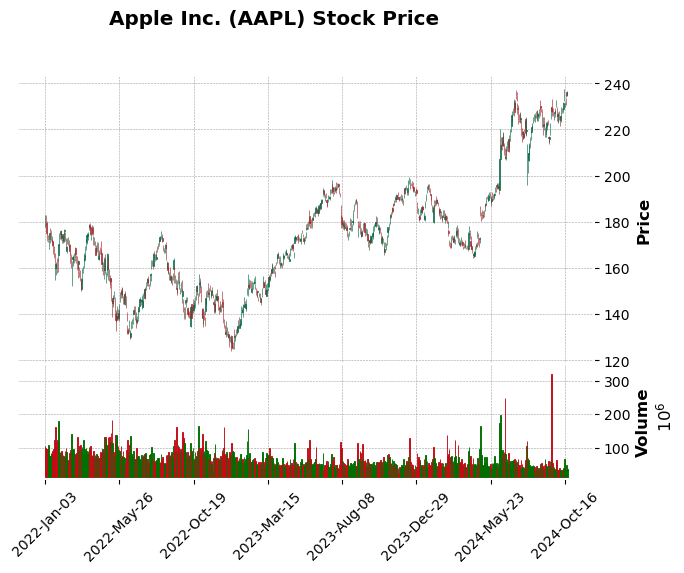

In [5]:
mpf.plot(stock_data, type='candle', style='charles', volume=True, title='Apple Inc. (AAPL) Stock Price', ylabel='Price', ylabel_lower='Volume', show_nontrading=False)

In [6]:
data = stock_data.drop(columns=['Adj Close'], inplace=False)
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2022-01-03,177.830002,182.880005,177.710007,182.009995,104487900
2022-01-04,182.630005,182.940002,179.119995,179.699997,99310400
2022-01-05,179.610001,180.169998,174.639999,174.919998,94537600
2022-01-06,172.699997,175.300003,171.639999,172.000000,96904000
2022-01-07,172.889999,174.139999,171.029999,172.169998,86709100


In [7]:
data.shape

(704, 5)

In [8]:
Numpy_Data = data.to_numpy()
Numpy_Data

array([[1.77830002e+02, 1.82880005e+02, 1.77710007e+02, 1.82009995e+02,
        1.04487900e+08],
       [1.82630005e+02, 1.82940002e+02, 1.79119995e+02, 1.79699997e+02,
        9.93104000e+07],
       [1.79610001e+02, 1.80169998e+02, 1.74639999e+02, 1.74919998e+02,
        9.45376000e+07],
       ...,
       [2.33429993e+02, 2.33850006e+02, 2.30520004e+02, 2.32149994e+02,
        3.29938000e+07],
       [2.36179993e+02, 2.36179993e+02, 2.34009995e+02, 2.35000000e+02,
        4.64315000e+07],
       [2.34449997e+02, 2.36850006e+02, 2.34449997e+02, 2.36479996e+02,
        3.62208000e+07]])

In [9]:
Numpy_Data.shape

(704, 5)

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(Numpy_Data)

In [11]:
scaled_data

array([[0.46908665, 0.50227856, 0.48549156, 0.51130449, 0.27301756],
       [0.5125374 , 0.50282539, 0.49827709, 0.49057959, 0.25544477],
       [0.48519962, 0.47757927, 0.45765326, 0.44769426, 0.23924555],
       ...,
       [0.97239067, 0.96682465, 0.9643635 , 0.96115197, 0.03036164],
       [0.9972843 , 0.9880604 , 0.99601013, 0.98672173, 0.07597013],
       [0.98162398, 0.99416698, 1.        , 1.        , 0.04131431]])

In [12]:
len(scaled_data)

704

In [13]:
train_size = int(len(scaled_data) * 0.7)  # Use 70% for training
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]
train_data

array([[0.46908665, 0.50227856, 0.48549156, 0.51130449, 0.27301756],
       [0.5125374 , 0.50282539, 0.49827709, 0.49057959, 0.25544477],
       [0.48519962, 0.47757927, 0.45765326, 0.44769426, 0.23924555],
       ...,
       [0.62532813, 0.64008383, 0.64091412, 0.65440526, 0.15733513],
       [0.65185124, 0.65484864, 0.65279295, 0.65575098, 0.14520948],
       [0.6474156 , 0.64372942, 0.66040989, 0.65090626, 0.35369051]])

In [14]:
def create_dataset(dataset, time_step=14):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0:5])
        y.append(dataset[i, 3]) #predicting only value for closing price
    return np.array(X), np.array(y)

In [77]:
time_step = 7  # Use the past 7 days to predict the next day's price
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_test

array([[[0.63438036, 0.62759755, 0.63674285, 0.63583351, 0.10760421],
        [0.63501408, 0.63051399, 0.6503446 , 0.64525396, 0.05656488],
        [0.64171264, 0.63716725, 0.64073272, 0.6263234 , 0.09569408],
        ...,
        [0.62614279, 0.61647832, 0.62386656, 0.61528809, 0.04437576],
        [0.61193086, 0.60262484, 0.62259707, 0.61035355, 0.01653251],
        [0.60179241, 0.59907034, 0.606819  , 0.61125065, 0.08159138]],

       [[0.63501408, 0.63051399, 0.6503446 , 0.64525396, 0.05656488],
        [0.64171264, 0.63716725, 0.64073272, 0.6263234 , 0.09569408],
        [0.63447097, 0.63169887, 0.62867249, 0.62497754, 0.07614322],
        ...,
        [0.61193086, 0.60262484, 0.62259707, 0.61035355, 0.01653251],
        [0.60179241, 0.59907034, 0.606819  , 0.61125065, 0.08159138],
        [0.61672853, 0.60964274, 0.62568009, 0.61510861, 0.03394612]],

       [[0.64171264, 0.63716725, 0.64073272, 0.6263234 , 0.09569408],
        [0.63447097, 0.63169887, 0.62867249, 0.62497754, 0.0

In [78]:
X_train.shape

(485, 7, 5)

In [79]:
y_train.shape

(485,)

In [86]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Predicting the next price


C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [87]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0698
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038
Epoch 13/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038
Epoch 14/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036
Epoch 15/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036
Epoch 16/20
16/16 ━

In [88]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [89]:
train_predict.shape

(485, 1)

In [90]:
# For train_predict
train_predict_reshaped = np.zeros((train_predict.shape[0], 5))  # Create an array with 5 features
#train_predict_reshaped
train_predict_reshaped[:, 3] = train_predict.flatten()  #  'Close' is at index 3
#train_predict_reshaped
train_predict_inverse = scaler.inverse_transform(train_predict_reshaped)
#train_predict_inverse

# For Test_predict
test_predict_reshaped = np.zeros((test_predict.shape[0],5))
test_predict_reshaped[:,3]=test_predict.flatten()
test_predict_inverse = scaler.inverse_transform(test_predict_reshaped)

#Compiling all predicted values
Complete_Predicted = np.concatenate((train_predict_inverse[:,3],test_predict_inverse[:,3]),axis=0)
Complete_Predicted

#Now working on actual prices
Actual_Price = Numpy_Data[:,3]
Actual_Price

array([182.00999451, 179.69999695, 174.91999817, 172.        ,
       172.16999817, 172.19000244, 175.08000183, 175.52999878,
       172.19000244, 173.07000732, 169.80000305, 166.22999573,
       164.50999451, 162.41000366, 161.61999512, 159.77999878,
       159.69000244, 159.22000122, 170.33000183, 174.77999878,
       174.61000061, 175.83999634, 172.8999939 , 172.38999939,
       171.66000366, 174.83000183, 176.27999878, 172.11999512,
       168.63999939, 168.88000488, 172.78999329, 172.55000305,
       168.88000488, 167.30000305, 164.32000732, 160.07000732,
       162.74000549, 164.8500061 , 165.11999512, 163.19999695,
       166.55999756, 166.22999573, 163.16999817, 159.30000305,
       157.44000244, 162.94999695, 158.52000427, 154.72999573,
       150.61999512, 155.08999634, 159.58999634, 160.61999512,
       163.97999573, 165.38000488, 168.82000732, 170.21000671,
       174.07000732, 174.72000122, 175.6000061 , 178.96000671,
       177.77000427, 174.61000061, 174.30999756, 178.44

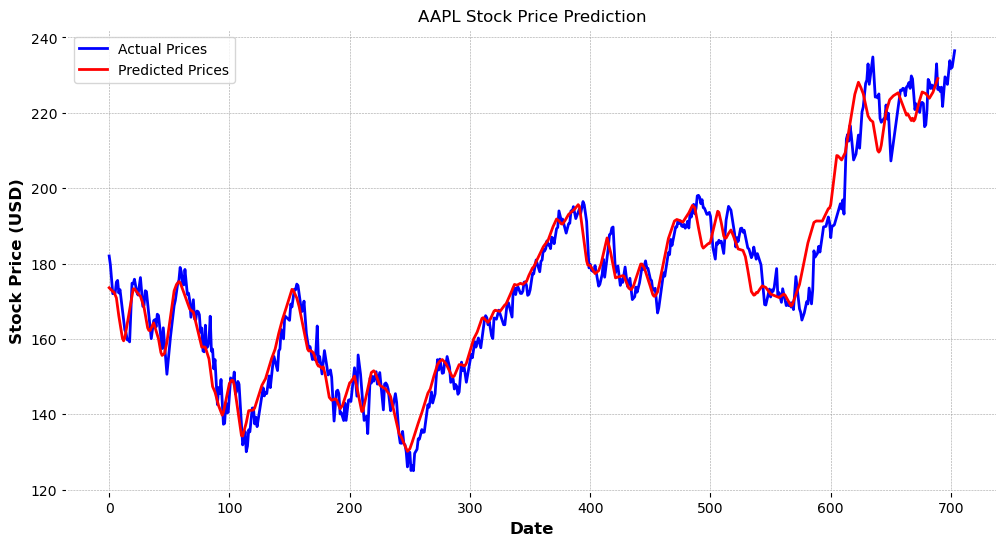

In [91]:
plt.figure(figsize=(12, 6))
plt.plot(Actual_Price, color='blue', label='Actual Prices')
plt.plot(Complete_Predicted, color='red', label='Predicted Prices')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()